In [2]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 23 μs, sys: 0 ns, total: 23 μs
Wall time: 24.3 μs


In [3]:


tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'


In [4]:
region_id = 69333
val_path = '/data/uscuni-ulce/val_morphotopes/prague_morphotopes.pq'

In [5]:
# region_id = 4

In [6]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)
morphotopes = gpd.read_parquet(val_path)

In [7]:


tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]


tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train[X_train.index >=0])), index=X_train[X_train.index >=0].index)
    .loc[tess_groups.index]
    .values
)

In [8]:
spatial_lags = [1, 2, 3, 4, 5]
kernels = ['gaussian', 'inverse', 'weights']
lag_types = ['_median', '_iqr', '_']
cluster_sizes = [50, 75, 100, 150, 250]
chars_to_drop = [
    [],
    ['stcSAl', 'stcOri'],
    [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
    ]
          
]
clips = [None, (-5,5), (-10, 10)]


linkage = 'ward'
metric = 'euclidean'
centroids = shapely.get_coordinates(tessellation.representative_point())

In [9]:
from core.generate_context import partial_weighted_percentile

In [10]:
from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters, get_tree
# # label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [11]:
min_cluster_size = 100
spatial_lag = 3
kernel='gaussian'

to_drop = []
# to_drop = ['stcSAl', 'stcOri']
to_drop = [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
]

# least important 10 features
to_drop = ['sdsLen', 'sssLin', 'ltcBuA', 'lcnClo', 'mtbSWR', 'ssbCor', 'xcnSCl',
       'mtdDeg', 'libNCo', 'sdbCoA']

lag_type = '_median'

clip = None
linkage='ward'
metric='euclidean'

In [12]:
%%time
lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10, bandwidth=-1)
lag = lag[[c for c in lag.columns if lag_type in c]]

CPU times: user 4min 22s, sys: 21.9 s, total: 4min 44s
Wall time: 40.5 s


In [13]:
clustering_data = X_train.join(lag, how='inner')

In [14]:
# clustering_data = X_train
# clip = None
# to_drop = []
# # to_drop = [
# #        'stcSAl',
# #        'ltkOri',
# #          'stbOri',
# #          'stcOri',
# #          'stbCeA'
# # ]
# # to_drop = ['sdsLen', 'sssLin', 'ltcBuA', 'lcnClo', 
# #            'mtbSWR', 'ssbCor', 'xcnSCl',
# #        'mtdDeg', 'libNCo', 'sdbCoA']
# # min_cluster_size = 100

In [36]:
clustering_data.shape

(461350, 126)

In [37]:
# to_drop = X_train.columns[~X_train.columns.str.startswith('s')]

# to_drop = X_train.columns[~X_train.columns.isin(['sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI',
#        'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'mtbSWR',  'libNCo', 'ldbPWL'])]

# to_drop

In [17]:
%%time
region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)

CPU times: user 1min 9s, sys: 532 ms, total: 1min 9s
Wall time: 1min 9s


In [18]:
from sklearn.metrics import silhouette_score

In [19]:
silhouette_score(clustering_data.iloc[tess_groups_ilocs].fillna(0), region_cluster_labels[tess_groups_ilocs])

np.float64(-0.7030808125758731)

In [20]:
adjusted_rand_score(tess_groups.values, region_cluster_labels[tess_groups_ilocs])

0.4874154950461761

In [21]:
np.unique(region_cluster_labels).shape

(5266,)

In [22]:
labels.value_counts()

component labels
849     123429
130      21674
192      16977
62        5988
76        5738
         ...  
2543         1
5            1
3535         1
3534         1
3533         1
Name: count, Length: 3559, dtype: int64

In [27]:
label = 849
labels.groupby(labels).get_group(label).shape

(123429,)

In [28]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [29]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [30]:
## there is some issue here with the subsetting

In [31]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
# plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
plotting['label'] = region_cluster_labels.loc[labels.groupby(labels).get_group(label).index.values].values
# plotting['label'] = plotting['label']
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(123429, 4)

In [32]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [33]:
plotting['label'].nunique()

754

In [39]:
# buildings = gpd.read_parquet(buildings_dir + 'buildings_freiburg.parquet')
# plotting = buildings

In [34]:
%%time
import lonboard
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.18 s, sys: 188 ms, total: 2.36 s
Wall time: 2.36 s


In [35]:
from sidecar import Sidecar
sc = Sidecar(title='Morphotopes')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [38]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
morph_clrs_geometry = clrs_geometry.set_geometry('geometry').reset_index()

CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 33.2 s


In [39]:
morph_clrs_geometry.to_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [53]:
# gpd.read_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq').explore()

----

In [40]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [41]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [42]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [43]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [44]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 29.7 s, sys: 0 ns, total: 29.7 s
Wall time: 29.7 s


In [45]:
component_data

sdbAre                                  sdbPer             \
         percentile_10      median percentile_90 percentile_10     median   
0_1.0       137.301434  137.301434    137.301434     49.637208  49.637208   
1000_1.0     69.761003  145.329083    307.945212     37.725315  53.718509   
1001_1.0     25.583669  129.538040    186.875280     22.144582  52.926018   
1002_1.0    118.035971  122.679492    127.323013     48.107607  48.227610   
1003_1.0    201.428349  249.432694    297.437038     62.545208  71.563066   
...                ...         ...           ...           ...        ...   
997_0        47.652135  114.041376    216.513891     29.941004  48.286920   
998_1.0      31.203731   31.203731     31.203731     22.401346  22.401346   
999_1.0      26.737521   45.950070     65.117366     20.982470  27.661601   
99_1.0       55.810224   55.810224     55.810224     29.883778  29.883778   
9_0          65.028669  141.260134    287.622403     34.486032  55.486851   

                              sdbCoA                             ssbCCo  ...  \
         percentile_90 percentile_10 median percentile_90 percentile_10  ...   
0_1.0        49.637208           0.0    0.0           0.0      0.511269  ...   
1000_1.0     87.634723           0.0    0.0           0.0      0.270298  ...   
1001_1.0     68.413938           0.0    0.0           0.0      0.301244  ...   
1002_1.0     48.347614           0.0    0.0           0.0      0.522649  ...   
1003_1.0     80.580925           0.0    0.0           0.0      0.425380  ...   
...                ...           ...    ...           ...           ...  ...   
997_0        72.868818           0.0    0.0           0.0      0.331598  ...   
998_1.0      22.401346           0.0    0.0           0.0      0.630092  ...   
999_1.0      40.728214           0.0    0.0           0.0      0.465935  ...   
99_1.0       29.883778           0.0    0.0           0.0      0.630701  ...   
9_0          92.223459           0.0    0.0           0.0      0.280456  ...   

                ltkWNB        likWBB                                 sdsAre  \
         percentile_90 percentile_10    median percentile_90  percentile_10   
0_1.0         0.001511      0.004113  0.004113      0.004113   38168.233789   
1000_1.0      0.001413      0.038991  0.038991      0.072515   47338.884443   
1001_1.0      0.000702      0.008362  0.008362      0.008362  182189.605271   
1002_1.0      0.002963      0.008190  0.008190      0.008190  156188.972066   
1003_1.0      0.001357      0.012059  0.012059      0.012059  156188.972066   
...                ...           ...       ...           ...            ...   
997_0         0.004827      0.048820  0.052363      0.071792    8405.044972   
998_1.0       0.001576      0.001021  0.001021      0.001021  315813.378416   
999_1.0       0.000327      0.014052  0.014052      0.014052  315813.378416   
99_1.0        0.001557      0.001781  0.001781      0.001781   68026.422726   
9_0           0.008860      0.039494  0.061224      0.126033    8017.188260   

                                              likWCe                          
                 median  percentile_90 percentile_10    median percentile_90  
0_1.0      38168.233789   38168.233789      0.000030  0.000030      0.000030  
1000_1.0   94253.544525  182189.605271      0.000209  0.000249      0.000249  
1001_1.0  249001.491843  612195.650949      0.000075  0.000075      0.000075  
1002_1.0  156188.972066  156188.972066      0.000067  0.000067      0.000067  
1003_1.0  156188.972066  156188.972066      0.000048  0.000048      0.000048  
...                 ...            ...           ...       ...           ...  
997_0      31024.187868   49323.330922      0.000377  0.000414      0.000418  
998_1.0   315813.378416  315813.378416      0.000033  0.000033      0.000033  
999_1.0   315813.378416  315813.378416      0.000261  0.000261      0.000261  
99_1.0     68026.422726   68026.422726      0.000032  0.000032      0.000032

In [46]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

In [47]:

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [48]:
# component_data = component_data.clip(-10, 10)

In [49]:
# component_data = component_data[component_data.columns[component_data.columns.get_level_values(1).str.contains('median')]]

In [50]:
# dists, component_data.iloc[idxs[0]].index

In [51]:
# from sklearn.neighbors import KDTree
# tree = KDTree(component_data.values)
# dists, idxs = tree.query(component_data.loc[['3_6']].values, k=10)

# morph_clrs_geometry.set_index('label').loc[component_data.iloc[idxs[0]].index].explore(column=dists[0], )

In [52]:
umap_metric ='euclidean'
n_neighbors = 10

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

<Axes: >

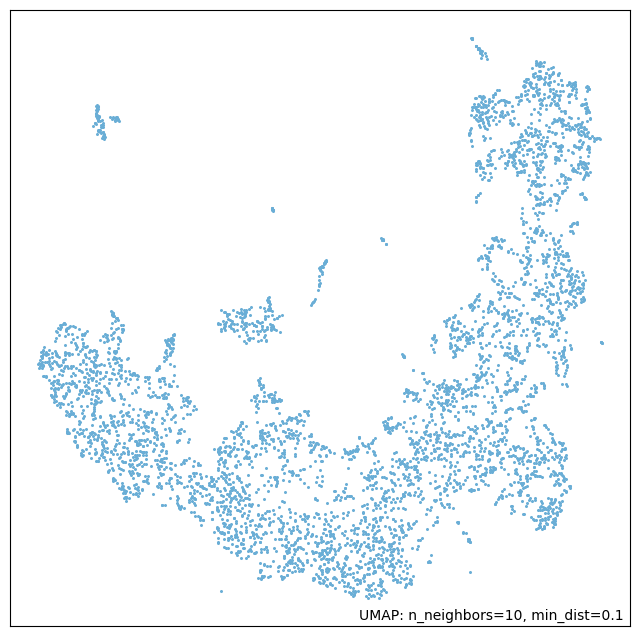

In [53]:
import umap
import umap.plot
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, 
                    negative_sample_rate=50, min_dist=0.1, metric=umap_metric, verbose=False, random_state=1)
emb = reducer.fit_transform(component_data)
umap.plot.points(reducer)

In [54]:
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)
embedding = reducer.fit_transform(component_data)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Tue Oct  1 13:35:11 2024 Construct fuzzy simplicial set
Tue Oct  1 13:35:11 2024 Finding Nearest Neighbors
Tue Oct  1 13:35:11 2024 Building RP forest with 9 trees
Tue Oct  1 13:35:11 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Tue Oct  1 13:35:11 2024 Finished Nearest Neighbor Search
Tue Oct  1 13:35:11 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Oct  1 13:35:56 2024 Finished embedding


In [55]:
tr_data = embedding
# tr_data = component_data

In [87]:
final_linkage = 'ward'
final_metric = 'euclidean'

In [88]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    metric=final_metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(tr_data)
linkage_matrix = get_linkage_matrix(model)

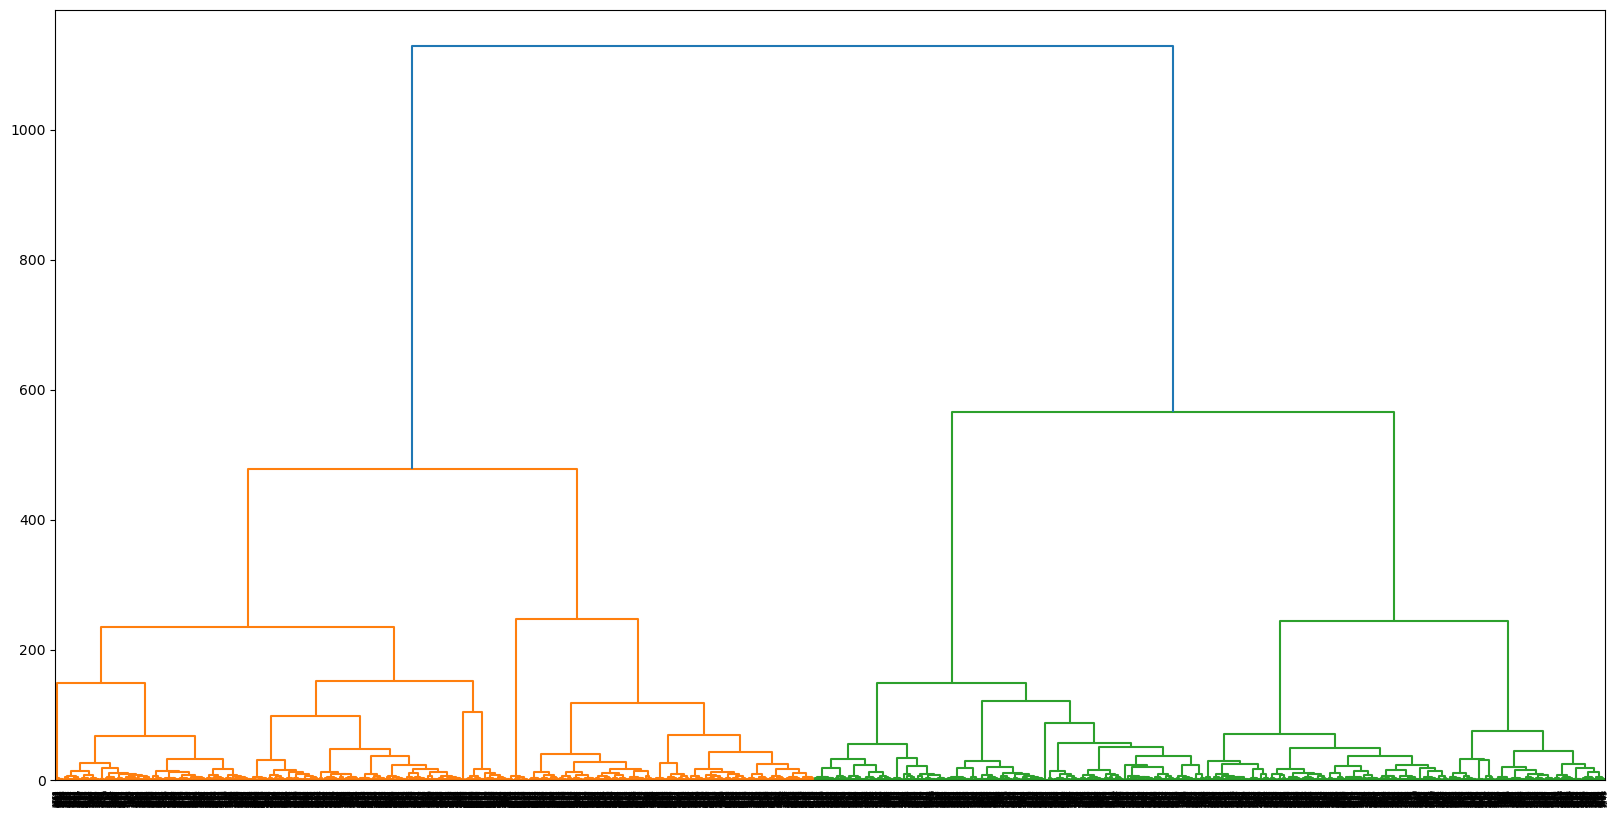

In [89]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [118]:
cutoff = 50

In [119]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
np.unique(clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int32)

In [120]:
# gpd.read_parquet('../data/clusters_umap_freiburg_100_3_gaussian_euclidean_complete_chebyshev_5.pq').explore()

In [121]:


# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=15, max_iter=5000, n_init=300, random_state=1).fit(tr_data).labels_
# np.unique(clusters)

In [122]:

# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=n_neighbors)
# clusterer.fit(component_data)
# clusters = clusterer.labels_
# np.unique(clusters)

In [123]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [124]:
layer.get_fill_color = get_color(clusters)

In [125]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [70]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 7 s, sys: 471 ms, total: 7.47 s
Wall time: 7.47 s


In [71]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [72]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [284]:
# gpd.read_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq').explore()

In [285]:
fbc = gpd.read_parquet('../data/freiburg/freiburg_building_census.pq')

In [126]:
clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = clusters
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')
clrs_geometry = clrs_geometry.reset_index()

In [287]:
# Overlay cells with clusters to get intersections
overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')

# Calculate the area of overlap
overlap['area'] = overlap.geometry.area

# Find the cluster with the largest overlap for each cell
largest_overlap = overlap.loc[overlap.groupby(overlap['ID'])['area'].idxmax()]

/tmp/ipykernel_589934/715595176.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')


In [288]:
cols = largest_overlap.columns[largest_overlap.columns.str.contains('19') | largest_overlap.columns.str.contains('19')].sort_values()
age_cols = [cols[-1]] + list(cols[:-1])
age_cols

res = largest_overlap.iloc[:, 2:].dissolve('label', aggfunc='sum')
res[age_cols]

,Before 1919,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000
label,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,535.0,118.0,359.0,69.0,6.0,19.0,18.0
4,1385.0,406.0,704.0,74.0,23.0,18.0,21.0
5,179.0,889.0,1000.0,174.0,34.0,21.0,43.0
6,200.0,151.0,402.0,13.0,10.0,18.0,135.0
7,81.0,319.0,1074.0,186.0,40.0,33.0,55.0
8,41.0,100.0,648.0,77.0,19.0,30.0,40.0
9,0.0,0.0,106.0,27.0,16.0,6.0,86.0


In [289]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[ind], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.347
  Kappa:    0.268



In [290]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[age_cols], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.231
  Kappa:    0.125



In [291]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False).iloc[:10]


1949 - 1978    0.320713
Before 1919    0.245733
1919 - 1948    0.212132
1979 - 1986    0.104255
1996 - 2000    0.065185
1991 - 1995    0.027025
1987 - 1990    0.024956
dtype: float64

In [127]:
clrs_geometry.to_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq')

In [128]:
component_data.to_parquet(f'../data/morphotopes_data_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [ ]:
# gkf = model_selection.StratifiedGroupKFold(n_splits=5)
# splits = gkf.split(
#     largest_overlap[ind],
#     largest_overlap["label"].astype(str),
#     groups=largest_overlap["label"],
# )

In [ ]:
# split_label = np.empty(len(largest_overlap), dtype=float)
# for i, (train, test) in enumerate(splits):
#     split_label[test] = i
# largest_overlap["split"] = split_label

In [ ]:
# ax = largest_overlap.plot(
#   "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
# )
# largest_overlap.dissolve("label").convex_hull.boundary.plot(
#     ax=ax, color="k", linewidth=0.5, markersize=0
# )
# ax.set_axis_off()

In [ ]:
from libpysal import graph
import esda


In [ ]:
col = '1979 - 1986'

In [ ]:
contiguity = graph.Graph.build_contiguity(fbc, rook=False)
contiguity_r = contiguity.transform("r")
lisa = esda.Moran_Local(fbc[col].fillna(0), contiguity_r)

In [ ]:
# lisa.explore(
# fbc,
# crit_value=0.05,
#   prefer_canvas=True,
#   tiles="CartoDB Positron",
# )

---

### bandwidth stuff

In [11]:
from scipy.optimize import minimize, least_squares, root_scalar, brentq
from numba import njit
from scipy.fftpack import fft

@njit(cache=True)
def histogram(data, bins, range_hist=None):
    """Jitted histogram.

    Parameters
    ----------
    data : array-like
        Input data. Passed as first positional argument to ``np.histogram``.
    bins : int or array-like
        Passed as keyword argument ``bins`` to ``np.histogram``.
    range_hist : (float, float), optional
        Passed as keyword argument ``range`` to ``np.histogram``.

    Returns
    -------
    hist : array
        The number of counts per bin.
    density : array
        The density corresponding to each bin.
    bin_edges : array
        The edges of the bins used.
    """
    hist, bin_edges = np.histogram(data, bins=bins, range=range_hist)
    hist_dens = hist / (hist.sum() * np.diff(bin_edges))
    return hist, hist_dens, bin_edges


def _root(n_p, k_sq, a_sq, x):
    def _fixed_point(t_s, x_len, k_sq, a_sq):
        """Calculate t-zeta*gamma^[l](t).

        Implementation of the function t-zeta*gamma^[l](t) derived from equation (30) in [1].

        References
        ----------
        .. [1] Kernel density estimation via diffusion.
        Z. I. Botev, J. F. Grotowski, and D. P. Kroese.
        Ann. Statist. 38 (2010), no. 5, 2916--2957.
        """
        k_sq = np.asarray(k_sq, dtype=np.float64)
        a_sq = np.asarray(a_sq, dtype=np.float64)

        k_o = 7
        func = np.sum(np.power(k_sq, k_o) * a_sq * np.exp(-k_sq * np.pi**2 * t_s))
        func *= 0.5 * np.pi ** (2.0 * k_o)

        for ite in np.arange(k_o - 1, 2 - 1, -1):
            c_1 = (1 + 0.5 ** (ite + 0.5)) / 3
            c_2 = np.prod(np.arange(1.0, 2 * ite + 1, 2, dtype=np.float64))
            c_2 /= (np.pi / 2) ** 0.5
            t_j = np.power((c_1 * (c_2 / (x_len * func))), (2.0 / (3.0 + 2.0 * ite)))
            func = np.sum(k_sq**ite * a_sq * np.exp(-k_sq * np.pi**2.0 * t_j))
            func *= 0.5 * np.pi ** (2 * ite)

        out = t_s - (2 * x_len * np.pi**0.5 * func) ** (-0.4)
        return out

    # The right bound is at most 0.01
    found = False
    n_p = max(min(1050, n_p), 50)
    tol = 10e-12 + 0.01 * (n_p - 50) / 1000

    while not found:
        try:
            band_w, res = brentq(
                _fixed_point, 0, 0.01, args=(n_p, k_sq, a_sq), full_output=True, disp=False
            )
            found = res.converged
        except ValueError:
            band_w = 0
            tol *= 2.0
            found = False
        if band_w <= 0 or tol >= 1:
            band_w = (_bw_silverman(x) / np.ptp(x)) ** 2
            return band_w
    return band_w

def _dct1d(x):
    """Discrete Cosine Transform in 1 Dimension.

    Parameters
    ----------
    x : numpy array
        1 dimensional array of values for which the
        DCT is desired

    Returns
    -------
    output : DTC transformed values
    """
    x_len = len(x)

    even_increasing = np.arange(0, x_len, 2)
    odd_decreasing = np.arange(x_len - 1, 0, -2)

    x = np.concatenate((x[even_increasing], x[odd_decreasing]))

    w_1k = np.r_[1, (2 * np.exp(-(0 + 1j) * (np.arange(1, x_len)) * np.pi / (2 * x_len)))]
    output = np.real(w_1k * fft(x))

    return output


def _bw_isj(x, grid_counts=None, x_range=None):
    """Improved Sheather-Jones bandwidth estimation.

    Improved Sheather and Jones method as explained in [1]_. This method is used internally by the
    KDE estimator, resulting in saved computation time as minimums, maximums and the grid are
    pre-computed.

    References
    ----------
    .. [1] Kernel density estimation via diffusion.
       Z. I. Botev, J. F. Grotowski, and D. P. Kroese.
       Ann. Statist. 38 (2010), no. 5, 2916--2957.
    """
    x_len = len(x)
    grid_len = len(grid_counts) - 1
    # Discrete cosine transform of the data
    a_k = _dct1d(grid_counts / x_len)

    k_sq = np.arange(1, grid_len) ** 2
    a_sq = a_k[range(1, grid_len)] ** 2
    return _root(x_len, k_sq, a_sq, x) ** 0.5 * x_range




def kde(x):
    x = x[np.isfinite(x)]
    if x.size == 0 or np.all(x == x[0]):
        warnings.warn("Your data appears to have a single value or no finite values")

        return np.zeros(2), np.array([np.nan] * 2)

    grid_len = 256
    # Preliminary calculations
    x_min = x.min()
    x_max = x.max()
    x_range = x_max - x_min

    # Determine grid
    grid_min = x_min
    grid_max = x_max

    grid_counts, _, grid_edges = histogram(x, grid_len, (grid_min, grid_max))

    # Bandwidth estimation

    band_w = _bw_isj(x, grid_counts=grid_counts, x_range=x_range)
    return band_w

In [12]:
## distances
from sklearn.neighbors import KDTree

tree = KDTree(centroids)
dist, ind = tree.query(centroids, k=8)
dist = dist[:, 1:].ravel()
dist.sort()
kde(dist)

np.float64(4.765916614570653)

In [13]:
### hdbscan bandwith

In [14]:
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
    CondensedTree,
    bfs_from_hierarchy,
    eliminate_branch
)

In [15]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [16]:
kernel = 'gaussian'
spatial_lag = 3
lag_type = '_median'

In [63]:
%%time

X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')


lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
lag = lag[[c for c in lag.columns if lag_type in c]]
clustering_data = X_train.join(lag, how='inner')

X_train = clustering_data
X_train.shape

CPU times: user 4min 14s, sys: 21.7 s, total: 4min 36s
Wall time: 34.3 s


(460909, 126)

In [61]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [62]:
# to_drop = X_train.columns[~(X_train.columns.str.startswith('s') | X_train.columns.str.startswith('m'))]


to_drop = X_train.columns[X_train.columns.str.startswith('l')]


# to_drop = X_train.columns[~(X_train.columns.str.startswith('s') | X_train.columns.str.startswith('m'))]


In [63]:
X_train = X_train.drop(to_drop, axis=1)
X_train.columns

Index(['sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI',
       'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'mtbSWR', 'mtbAli', 'mtbNDi',
       'stbCeA', 'stbSAl', 'sdsLen', 'sssLin', 'sisBpM', 'sdsSPW', 'sdsSPO',
       'sdsSWD', 'mtdDeg', 'xcnSCl', 'mtdMDi', 'sddAre', 'midRea', 'midAre',
       'stcOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'mtcWNe', 'mdcAre',
       'sicCAR', 'stcSAl', 'sdsAre'],
      dtype='object')

In [79]:
# from core.utils import used_keys
# pd.Series(used_keys).loc[X_train.columns].values

array(['area of building', 'perimeter of building',
       'courtyard area of building', 'circular compactness of building',
       'corners of building', 'squareness of building',
       'equivalent rectangular index of building',
       'elongation of building',
       'centroid - corner mean distance of building',
       'centroid - corner distance deviation of building',
       'orientation of building', 'shared walls ratio of buildings',
       'alignment of neighbouring buildings',
       'mean distance between neighbouring buildings',
       'cell alignment of building', 'street alignment of building',
       'length of street segment', 'linearity of street segment',
       'buildings per meter of street segment', 'width of street profile',
       'openness of street profile', 'width deviation of street profile',
       'node degree of junction', 'square clustering of street network',
       'mean distance to neighbouring nodes of street network',
       'area covered by node-at

In [64]:
# label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

results = {}

for label, group in labels.groupby(labels):

    if label != 184 : continue

    if group.shape[0] <= min_cluster_size:
        component_clusters = np.ones(group.shape[0])

    else:
        component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values], clip=clip, to_drop=to_drop)
        component_graph = building_graph.subgraph(group.index.values)
        ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)
        break

In [65]:
component_buildings_data.shape

(140690, 38)

In [99]:
@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, bandwidth=1):
    root = 2 * hierarchy.shape[0]
    num_points = hierarchy.shape[0] + 1
    next_label = num_points + 1

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = num_points

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool_) # 'bool' is no longer an attribute of 'numpy'

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        if d > 0.0:
            # gaussian lambda value
            # lambda_value = np.exp(-(((d / bandwidth) / 2) ** 2)) / (np.sqrt(2) * np.pi)
            lambda_value = 1 / d
        else:
            lambda_value = np.inf

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else 1
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else 1

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

In [154]:

# import umap
# reducer = umap.UMAP(n_neighbors=10, n_components=20, 
#                     min_dist=0, negative_sample_rate=50, 
#                     metric='euclidean', verbose=True, random_state=1)
# embedding = reducer.fit_transform(component_buildings_data)

# ward_tree = get_tree(embedding, 
#                      component_graph.transform('B').sparse, 
#                      'ward', metric)

In [143]:


# ward_tree = get_tree(component_buildings_data, 
#                      component_graph.transform('B').sparse, 
#                      'ward', metric)

In [144]:
bandwidth = kde(ward_tree[:, 2])
bandwidth

np.float64(0.932801189896762)

In [145]:
from scipy.stats import gaussian_kde
e = gaussian_kde(ward_tree[:, 2])
f = e.covariance_factor()
bw = f * ward_tree[:, 2].std()
bw

np.float64(1.4053693940166059)

In [146]:
bandwidth = np.max((bandwidth, 1))
bandwidth = bw

In [147]:
min_cluster_size = 101

In [148]:

linkage_matrix = ward_tree
condensed_tree = condense_tree(linkage_matrix, 
                           min_cluster_size=min_cluster_size,
                              bandwidth=bandwidth)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [149]:
selected_clusters = extract_eom_clusters(
        condensed_tree, cluster_tree, allow_single_cluster=False
    )

In [150]:
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [151]:
pd.Series(clusters).value_counts()

-1      26927
 133     2051
 377     1505
 111     1384
 344     1378
        ...  
 340      103
 233      102
 33       101
 353      101
 209      101
Name: count, Length: 421, dtype: int64

In [152]:
# mt = gpd.read_parquet(val_path)
# mt.explore()

In [153]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [36]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation.loc[component_graph.unique_ids], opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.49 s, sys: 207 ms, total: 2.69 s
Wall time: 2.69 s


In [37]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [38]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)